In [ ]:
from google.colab import userdata
import zipfile
import os

os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d arezaei81/flights
!unzip "flights.zip"

Dataset URL: https://www.kaggle.com/datasets/arezaei81/flights
License(s): unknown
flights.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  flights.zip
replace flights.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.dpi'] = 120

sns.set(rc = {'axes.facecolor': '#F3E8FF'}, style = 'darkgrid')

In [ ]:
df = pd.read_csv('./flights.csv')

df.head()

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
0,0,2013,1,1,517.0,515,2.0,830.0,819,11.0,...,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
1,1,2013,1,1,533.0,529,4.0,850.0,830,20.0,...,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2,2,2013,1,1,542.0,540,2.0,923.0,850,33.0,...,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
3,3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,...,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
4,4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,...,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.


In [ ]:
df.shape

(336776, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              336776 non-null  int64  
 1   year            336776 non-null  int64  
 2   month           336776 non-null  int64  
 3   day             336776 non-null  int64  
 4   dep_time        328521 non-null  float64
 5   sched_dep_time  336776 non-null  int64  
 6   dep_delay       328521 non-null  float64
 7   arr_time        328063 non-null  float64
 8   sched_arr_time  336776 non-null  int64  
 9   arr_delay       327346 non-null  float64
 10  carrier         336776 non-null  object 
 11  flight          336776 non-null  int64  
 12  tailnum         334264 non-null  object 
 13  origin          336776 non-null  object 
 14  dest            336776 non-null  object 
 15  air_time        327346 non-null  float64
 16  distance        336776 non-null  int64  
 17  hour      

In [ ]:
df['id'] = df['id'].astype(str)
df['flight'] = df['flight'].astype(str)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,336776.0,2013.000000,0.000000,2013.0,2013.0,2013.0,2013.0,2013.0
month,336776.0,6.548510,3.414457,1.0,4.0,7.0,10.0,12.0
day,336776.0,15.710787,8.768607,1.0,8.0,16.0,23.0,31.0
dep_time,328521.0,1349.109947,488.281791,1.0,907.0,1401.0,1744.0,2400.0
sched_dep_time,336776.0,1344.254840,467.335756,106.0,906.0,1359.0,1729.0,2359.0
dep_delay,328521.0,12.639070,40.210061,-43.0,-5.0,-2.0,11.0,1301.0
arr_time,328063.0,1502.054999,533.264132,1.0,1104.0,1535.0,1940.0,2400.0
sched_arr_time,336776.0,1536.380220,497.457142,1.0,1124.0,1556.0,1945.0,2359.0
arr_delay,327346.0,6.895377,44.633292,-86.0,-17.0,-5.0,14.0,1272.0
air_time,327346.0,150.686460,93.688305,20.0,82.0,129.0,192.0,695.0


In [ ]:
df.describe(include = 'object').T

,count,unique,top,freq
id,336776,336776,0,1
carrier,336776,16,UA,58665
flight,336776,3844,15,968
tailnum,334264,4043,N725MQ,575
origin,336776,3,EWR,120835
dest,336776,105,ORD,17283
time_hour,336776,6936,2013-09-13 08:00:00,94
name,336776,16,United Air Lines Inc.,58665


In [ ]:
color = '#8502d1'

def plot_hist(column, bins, title, xlabel, fontsize=8, rotation=0):
  plt.figure(figsize=(8,4))

  counts, bins, patches = plt.hist(column, bins=bins, color=color, edgecolor='white')

  plt.title(title, fontsize=10)
  plt.xlabel(xlabel, fontsize=9)
  plt.ylabel('Frequency', fontsize=9)
  plt.xticks(fontsize = 8)
  plt.yticks(fontsize = 8)

  bin_centers = 0.5 * (bins[:-1] + bins[1:])
  for count, x in zip(counts, bin_centers):
      if count > 0:
          plt.text(x, count, str(int(count)), fontsize=fontsize, ha='center', va='bottom', rotation=rotation)
  plt.show()

def plot_bar(column, title, xlabel, fontsize=8, rotation=0):
  plt.figure(figsize=(8,4))

  counts = column.value_counts()
  counts.plot(kind='bar', color=color, edgecolor='white')

  plt.title(title, fontsize=10)
  plt.xlabel(xlabel, fontsize=9)
  plt.ylabel('Frequency', fontsize=9)
  plt.xticks(fontsize = 8)
  plt.yticks(fontsize = 8)

  for i, v in enumerate(counts):
      plt.text(i, v, str(v), fontsize=fontsize, ha='center', va='bottom', rotation=rotation)
  plt.show()

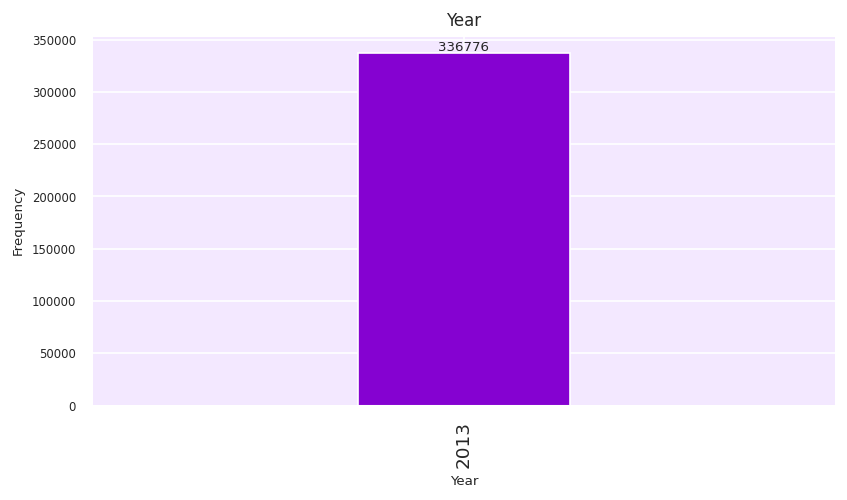

In [ ]:
plt.figure(figsize = (8, 4))

counts = df['year'].value_counts()
counts.plot(kind = 'bar', color = color, edgecolor = 'white', width = 0.2)

plt.title('Year', fontsize = 10)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Frequency', fontsize = 8)
plt.yticks(fontsize = 7)

for i, v in enumerate(counts):
  plt.text(i, v, str(v), fontsize = 8, ha = 'center', va = 'bottom')

plt.show()

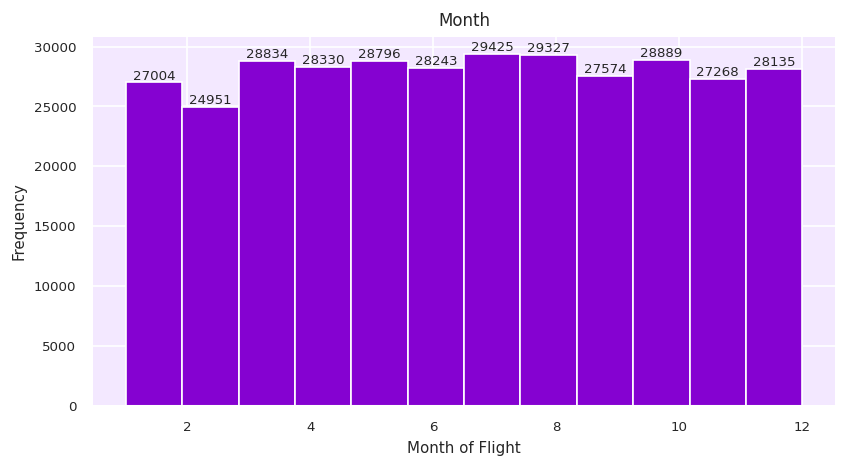

In [ ]:
plot_hist(df['month'], bins = 12, title = 'Month', xlabel = 'Month of Flight')

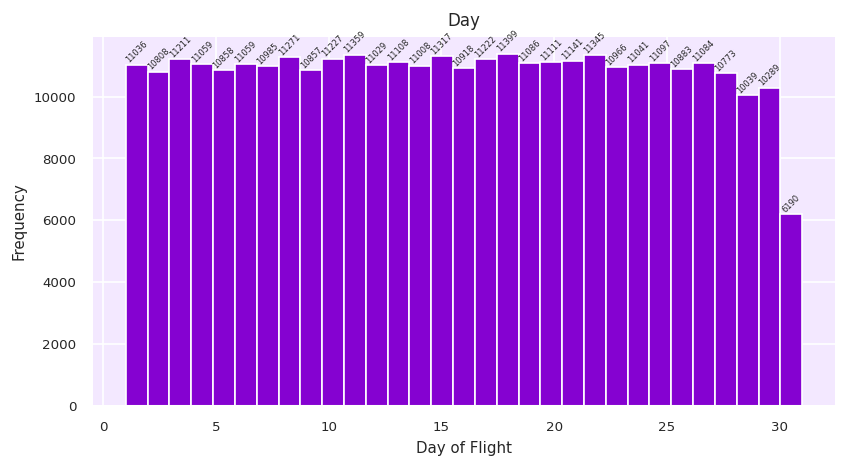

In [ ]:
plot_hist(df['day'], bins = 31, title = 'Day', xlabel = 'Day of Flight',
          fontsize = 5, rotation = 45)

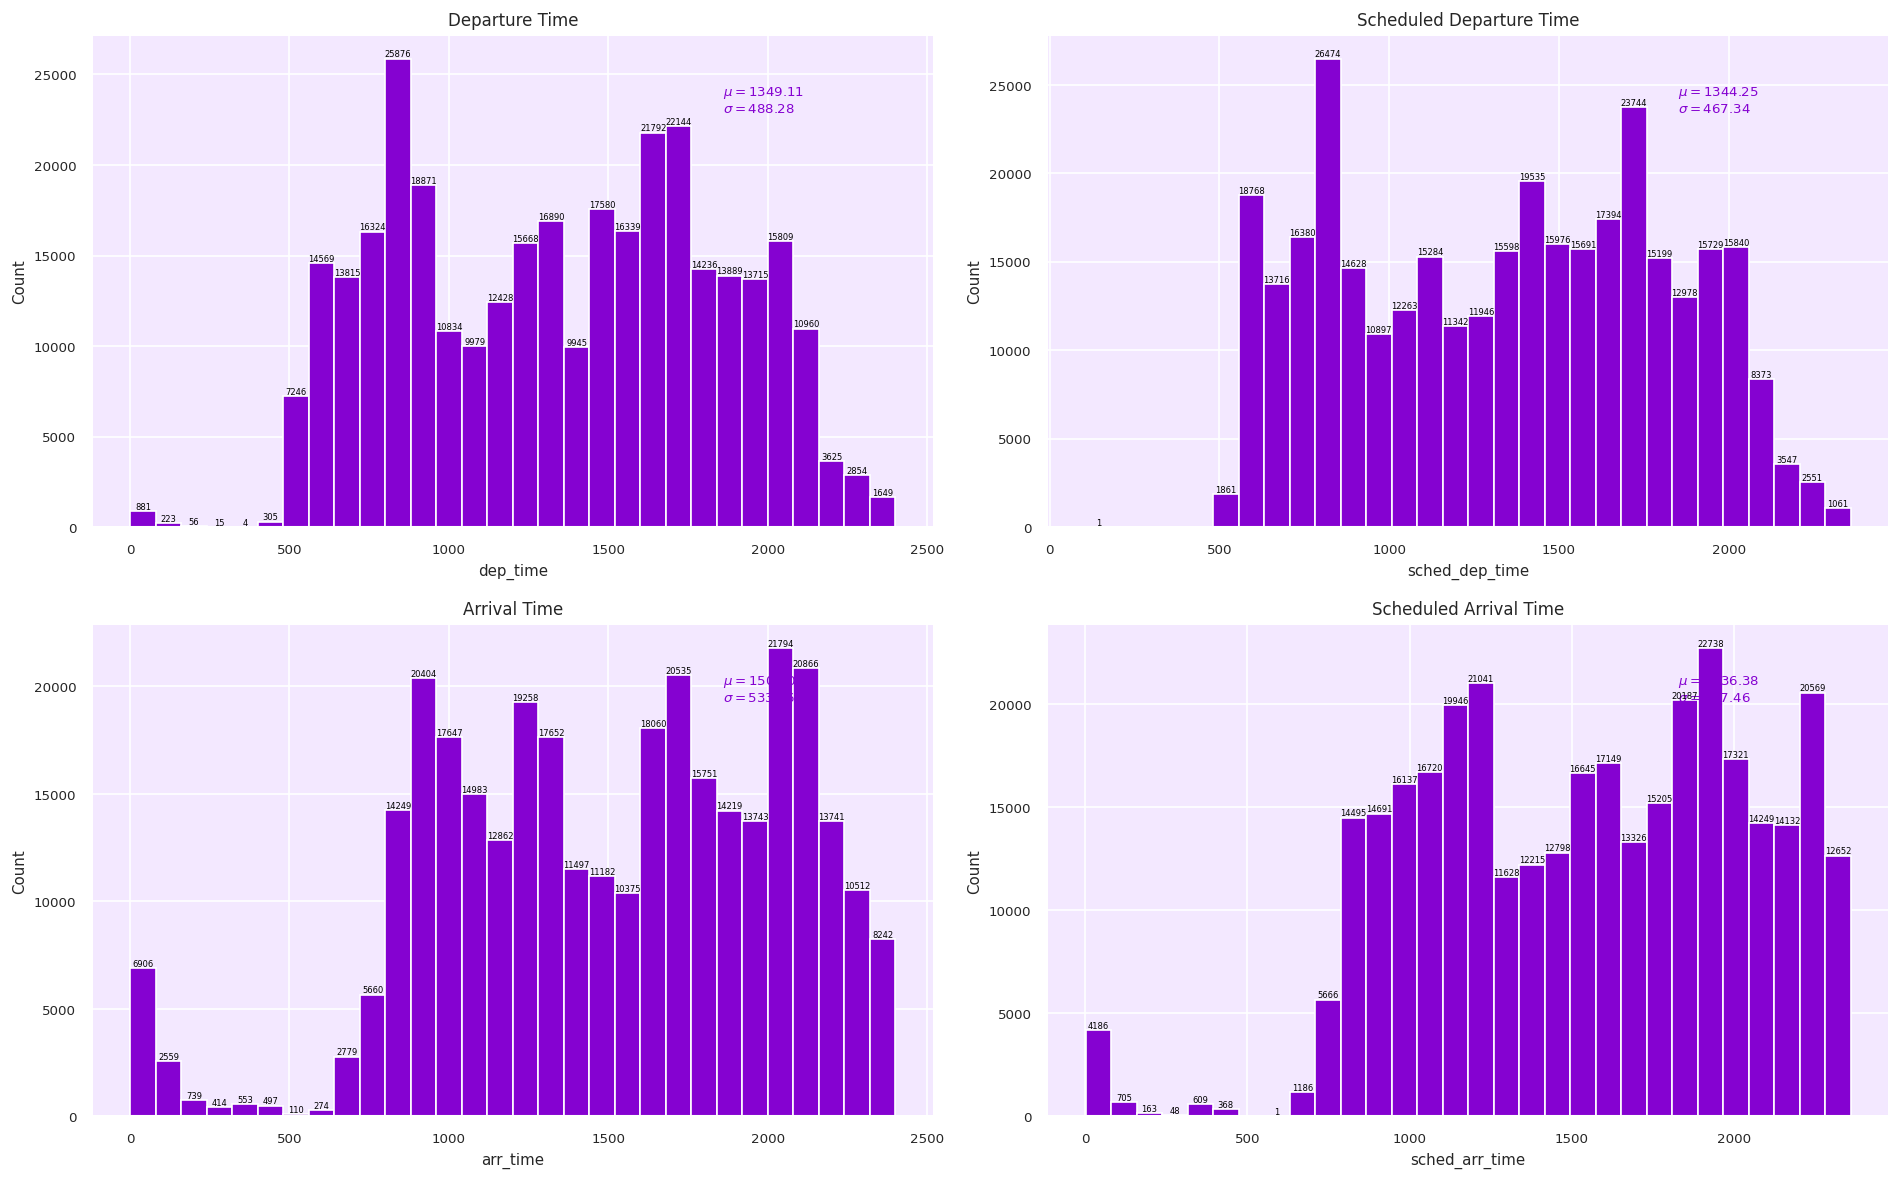

In [ ]:
to_plot = ['dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time']
titles = ['Departure Time', 'Scheduled Departure Time', 'Arrival Time',
          'Scheduled Arrival Time']

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for i, col in enumerate(to_plot):
  x = i // 2
  y = i % 2

  sns_hist = sns.histplot(data = df, x = col, bins = 30, color = color, alpha = 1,
                ax = ax[x, y])

  ax[x, y].set_xlabel(col, fontsize = 9)
  ax[x, y].set_ylabel('Count', fontsize = 9)
  ax[x, y].set_title(titles[i], fontsize = 10)
  ax[x, y].tick_params(axis='x', labelsize=8)
  ax[x, y].tick_params(axis='y', labelsize=8)

  text = '\n'.join((r'$\mu=%.2f$' % df[col].mean(),
                    r'$\sigma=%.2f$' % df[col].std()))

  ax[x, y].text(0.75, 0.9, text, transform = ax[x, y].transAxes, fontsize = 8,
                verticalalignment = 'top', color = color)

  for p in sns_hist.patches:
      height = p.get_height()
      if height > 0:
          ax[x, y].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom', fontsize=5, color='black')

plt.tight_layout()
plt.show()

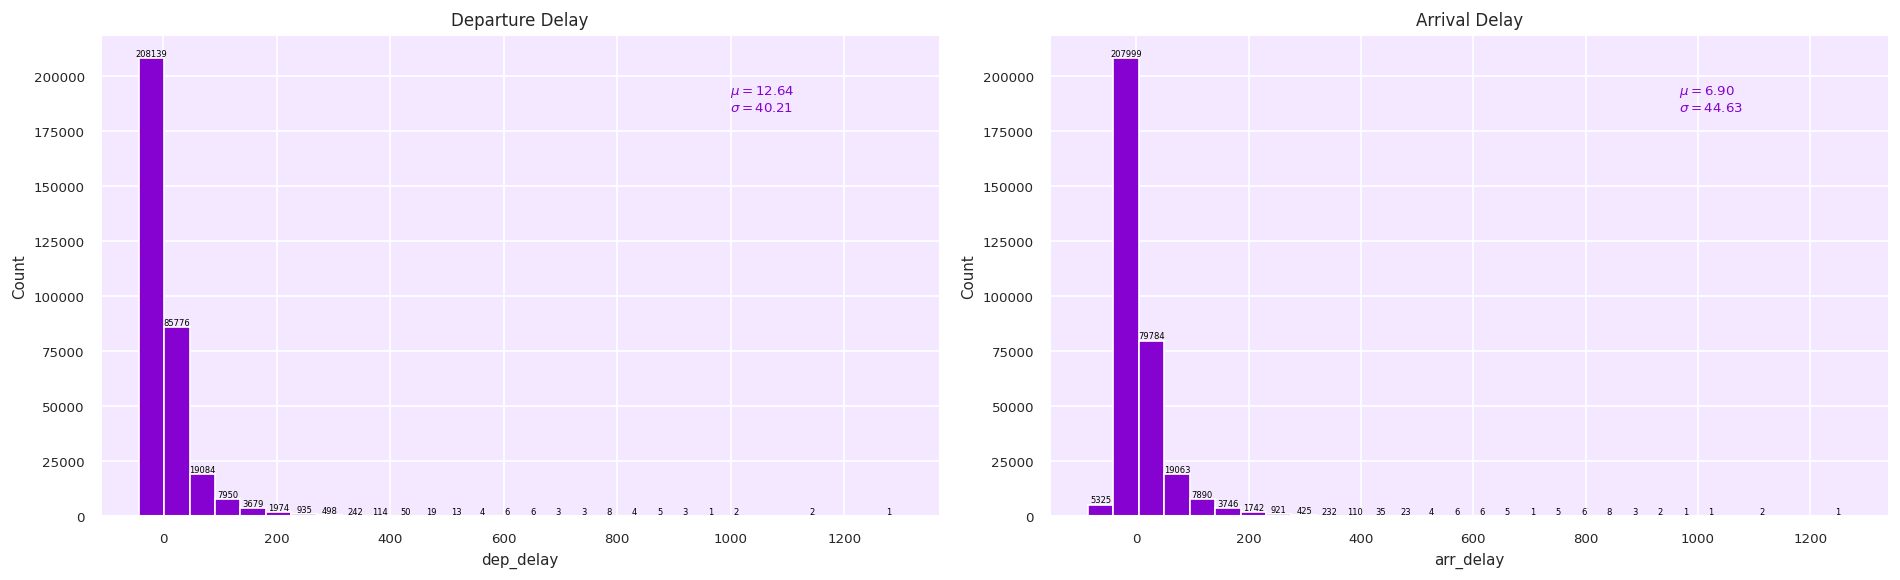

In [ ]:
to_plot = ['dep_delay', 'arr_delay']
titles = ['Departure Delay', 'Arrival Delay']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

for i, col in enumerate(to_plot):
  sns_hist = sns.histplot(data=df, x=col, bins=30, color=color, alpha=1,
                          ax=ax[i])

  ax[i].set_xlabel(col, fontsize = 9)
  ax[i].set_ylabel('Count', fontsize = 9)
  ax[i].set_title(titles[i], fontsize = 10)
  ax[i].tick_params(axis='x', labelsize=8)
  ax[i].tick_params(axis='y', labelsize=8)

  text = '\n'.join((r'$\mu=%.2f$' % df[col].mean(),
                    r'$\sigma=%.2f$' % df[col].std()))
  ax[i].text(0.75, 0.9, text, transform=ax[i].transAxes, fontsize=8,
              verticalalignment='top', color=color)

  for p in sns_hist.patches:
      height = p.get_height()
      if height > 0:
          ax[i].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom', fontsize=5, color='black')

plt.tight_layout()
plt.show()

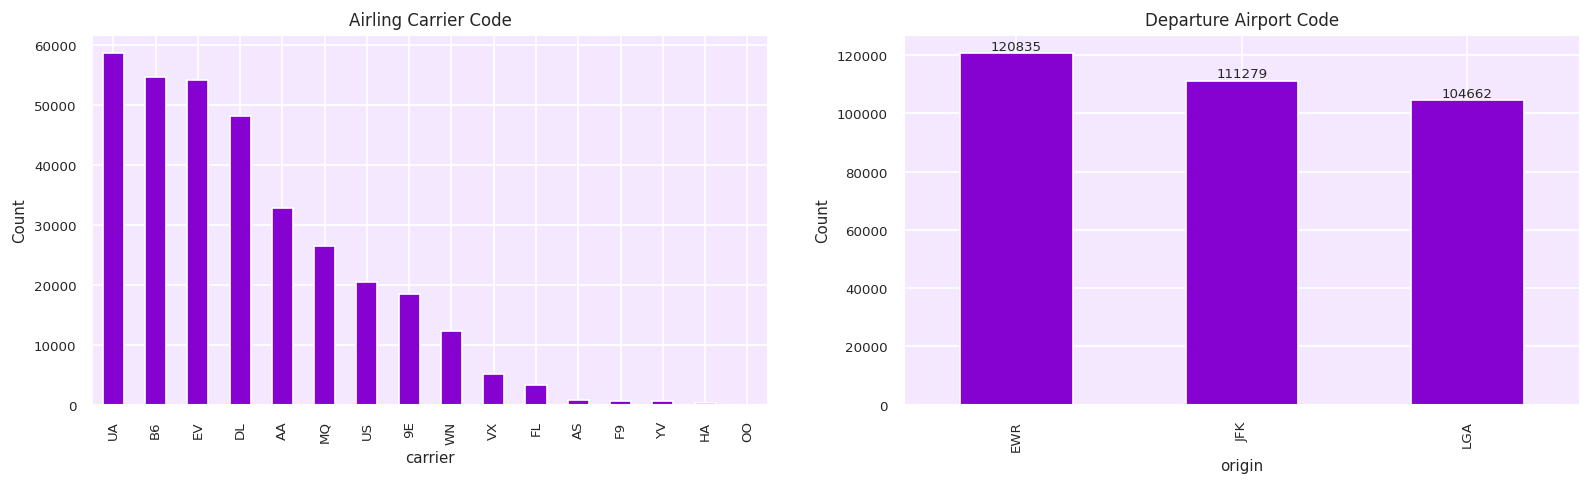

In [ ]:
to_plot = ['carrier', 'origin']
titles = ['Airling Carrier Code', 'Departure Airport Code']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 4))

for i, col in enumerate(to_plot):
  counts = df[col].value_counts()
  counts.plot(kind = 'bar', color = color, edgecolor = 'white', ax = ax[i])

  ax[i].set_xlabel(col, fontsize = 9)
  ax[i].set_ylabel('Count', fontsize = 9)
  ax[i].set_title(titles[i], fontsize = 10)
  ax[i].tick_params(axis='x', labelsize=8)
  ax[i].tick_params(axis='y', labelsize=8)

for i, v in enumerate(counts):
    plt.text(i, v, str(v), fontsize=8, ha='center', va='bottom',
             rotation=0)

plt.show()


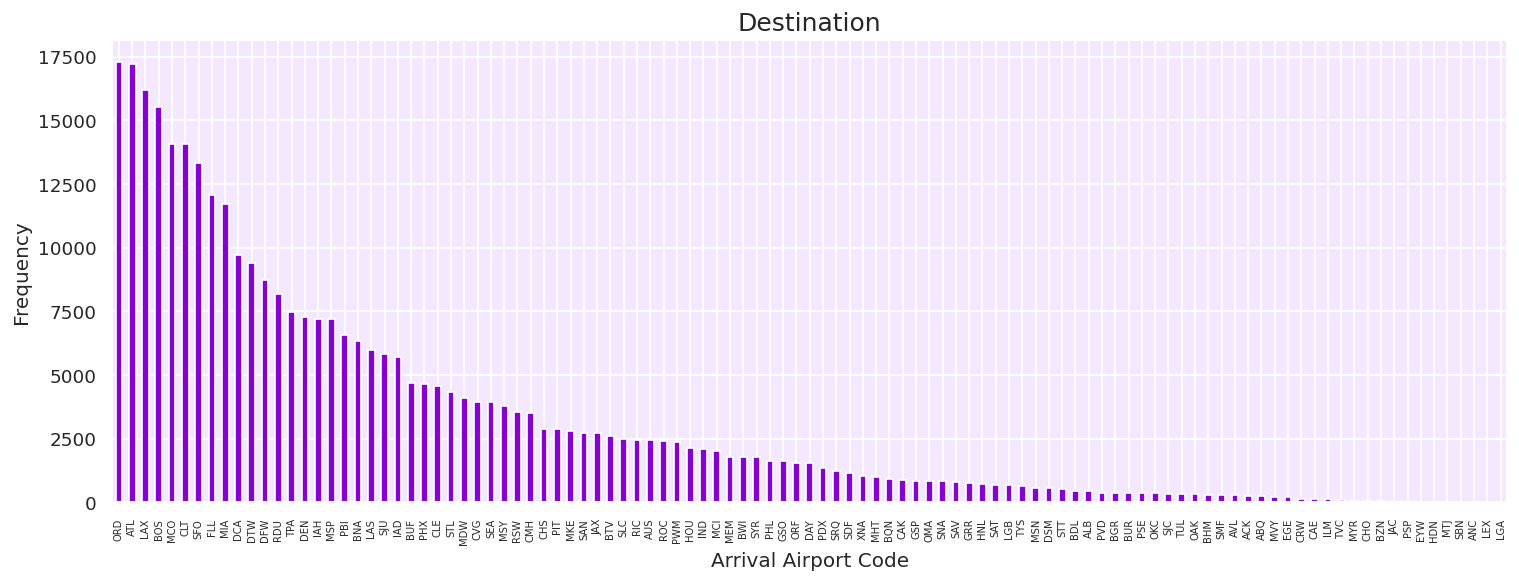

In [ ]:
plt.figure(figsize = (15, 5))

df['dest'].value_counts().plot(kind = 'bar', color = color)

plt.title("Destination", fontsize = 15)
plt.xlabel('Arrival Airport Code', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.xticks(fontsize = 6)
plt.show()

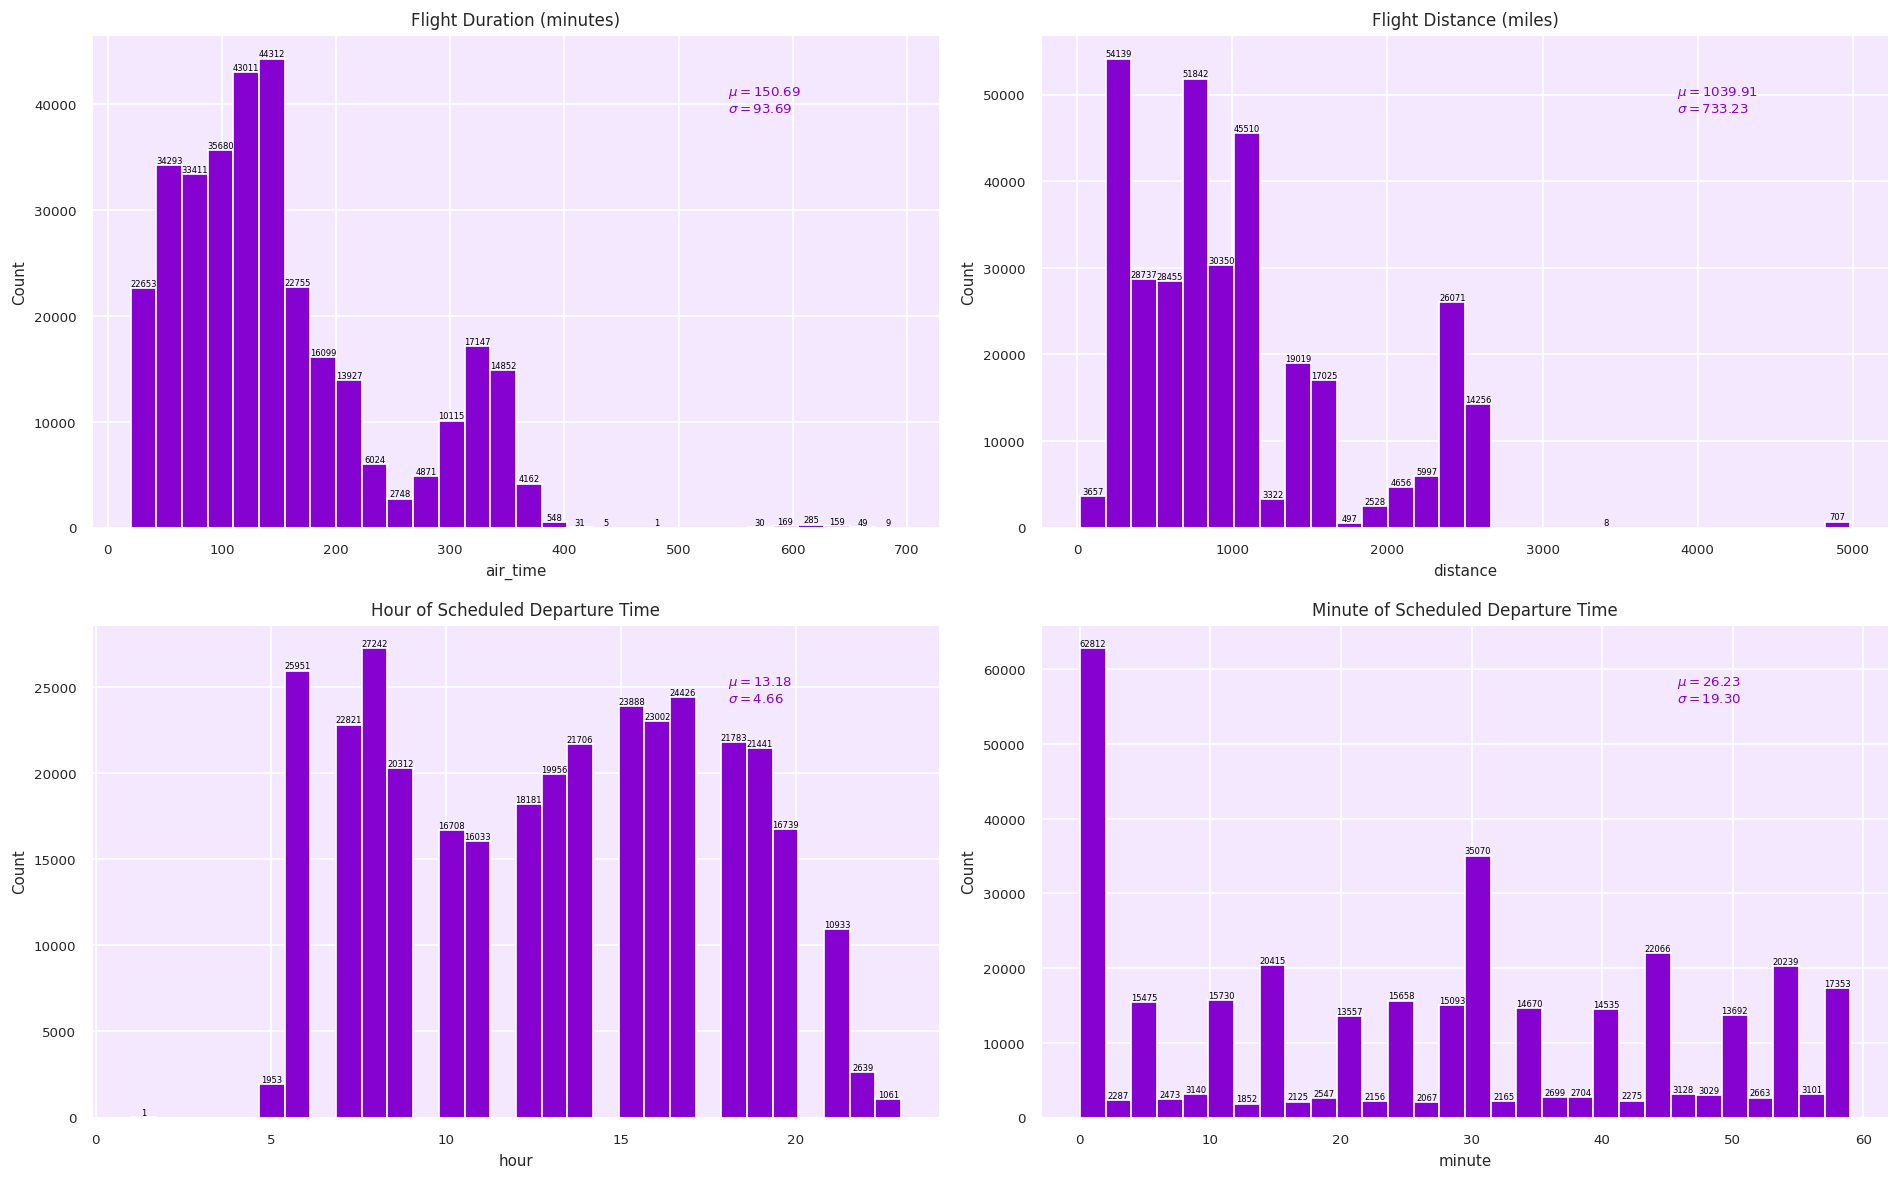

In [ ]:
to_plot = ['air_time', 'distance', 'hour', 'minute']
titles = ['Flight Duration (minutes)', 'Flight Distance (miles)',
          'Hour of Scheduled Departure Time', 'Minute of Scheduled Departure Time']

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for i, col in enumerate(to_plot):
  x = i // 2
  y = i % 2

  sns_hist = sns.histplot(data = df, x = col, bins = 30, color = color, alpha = 1,
                ax = ax[x, y])

  ax[x, y].set_xlabel(col, fontsize = 9)
  ax[x, y].set_ylabel('Count', fontsize = 9)
  ax[x, y].set_title(titles[i], fontsize = 10)
  ax[x, y].tick_params(axis='x', labelsize=8)
  ax[x, y].tick_params(axis='y', labelsize=8)

  text = '\n'.join((r'$\mu=%.2f$' % df[col].mean(),
                    r'$\sigma=%.2f$' % df[col].std()))

  ax[x, y].text(0.75, 0.9, text, transform = ax[x, y].transAxes, fontsize = 8,
                verticalalignment = 'top', color = color)

  for p in sns_hist.patches:
      height = p.get_height()
      if height > 0:
          ax[x, y].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom', fontsize=5, color='black')

plt.tight_layout()
plt.show()

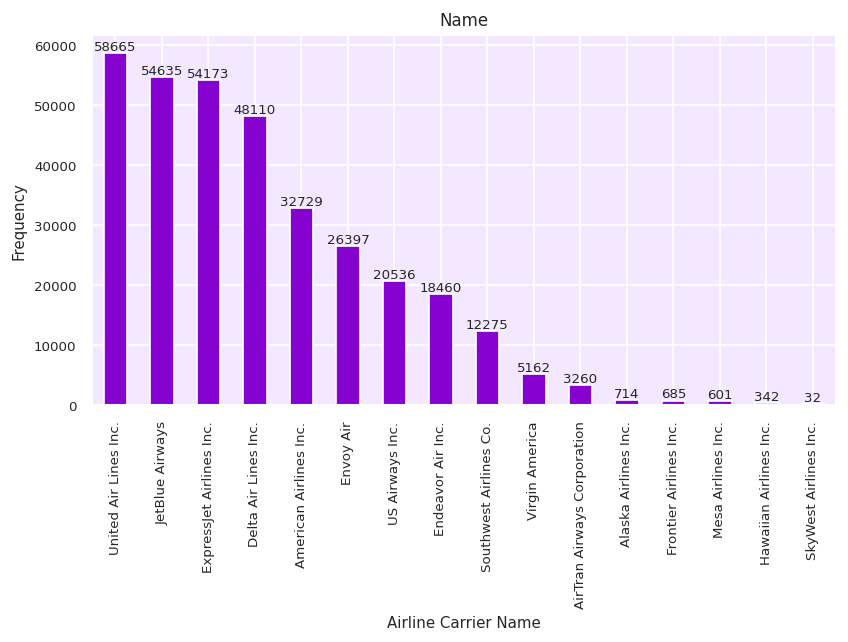

In [ ]:
plot_bar(df['name'], 'Name', 'Airline Carrier Name')

In [ ]:
colors_box = sns.dark_palette("#8502d1", as_cmap=False)

colors_scatter = sns.dark_palette(color, as_cmap=True)

def plot_scatter(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8,5))
    plt.scatter(x, y, c=y, cmap=colors_scatter, s=2)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.colorbar(label=ylabel)
    plt.show()

def plot_violin(x, y, title, xlabel, ylabel, fontsize=8):
    plt.figure(figsize=(10,5))
    sns.violinplot(x=x, y=y, palette=colors_box)
    plt.title(title, fontsize=10)
    plt.xlabel(xlabel, fontsize=9)
    plt.ylabel(ylabel, fontsize=9)
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.show()

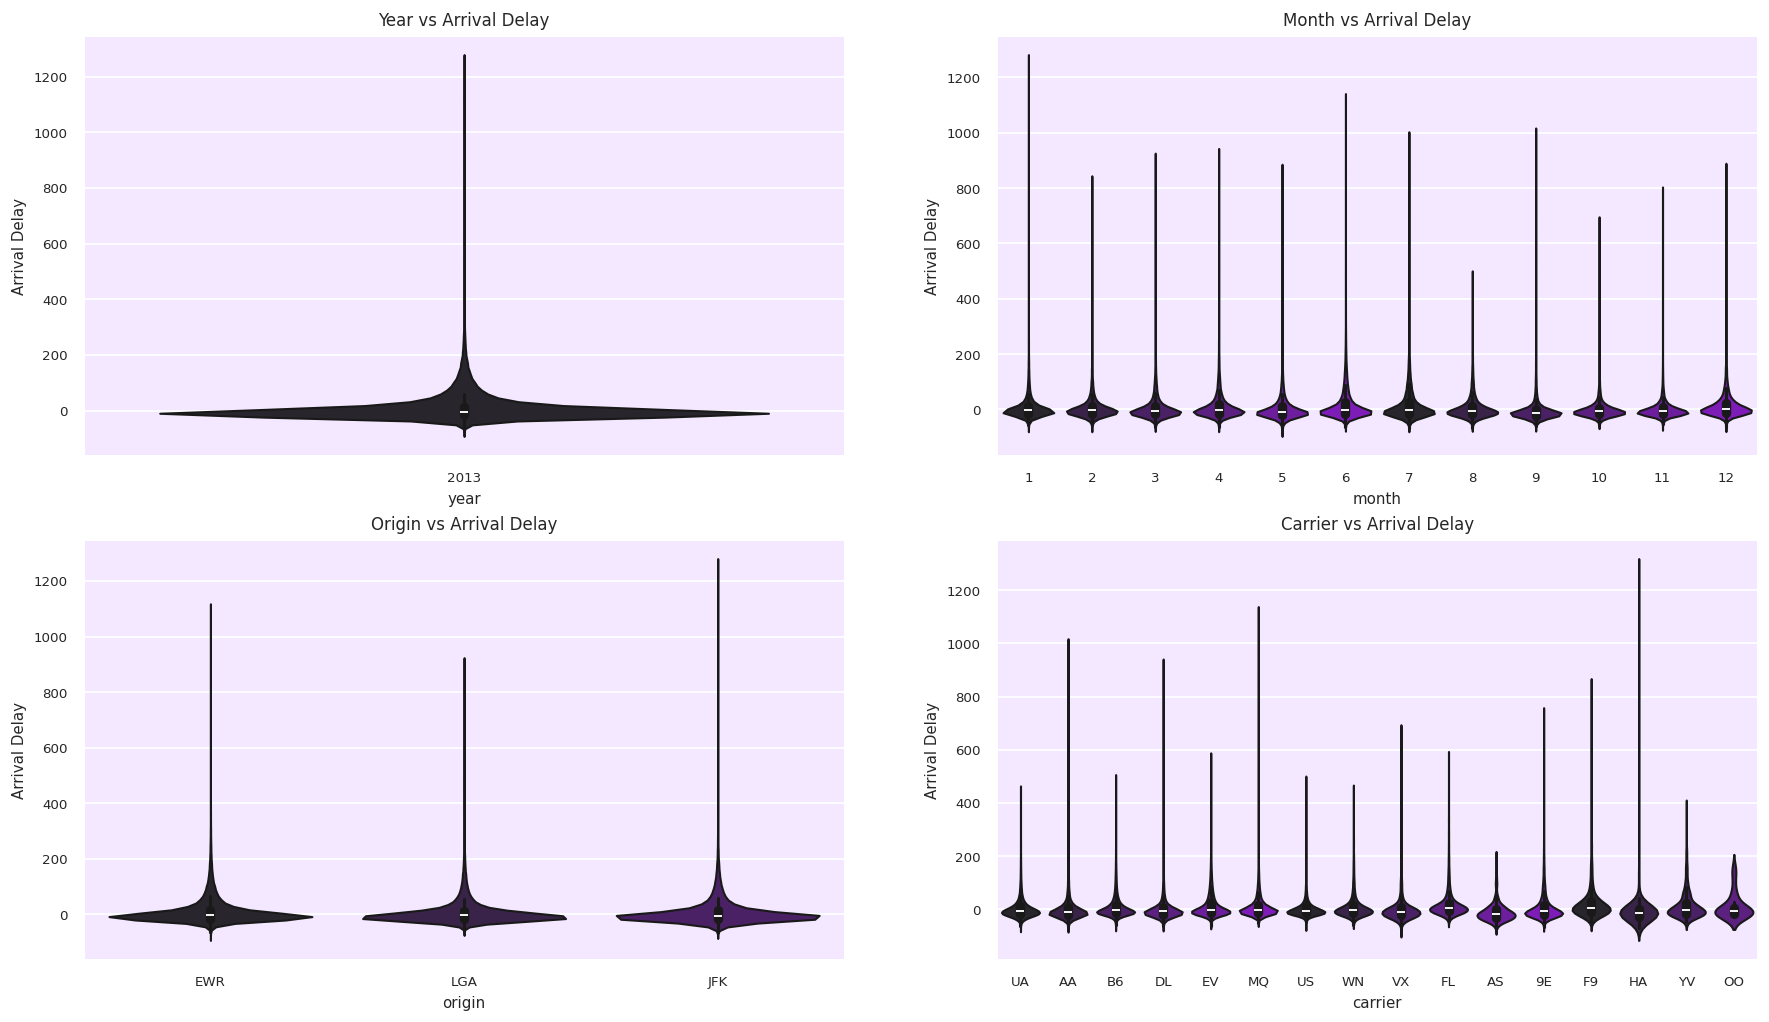

In [ ]:
to_plot = ['year', 'month', 'origin', 'carrier']
titles = ['Year vs Arrival Delay', 'Month vs Arrival Delay',
          'Origin vs Arrival Delay', 'Carrier vs Arrival Delay']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

for i, col in enumerate(to_plot):
  x = i // 2
  y = i % 2

  sns.violinplot(x = df[col], y = df['arr_delay'], palette = colors_box,
                 ax = ax[x, y])

  ax[x, y].set_xlabel(col, fontsize = 9)
  ax[x, y].set_ylabel('Arrival Delay', fontsize = 9)
  ax[x, y].set_title(titles[i], fontsize = 10)
  ax[x, y].tick_params(axis='x', labelsize=8)
  ax[x, y].tick_params(axis='y', labelsize=8)

plt.show()

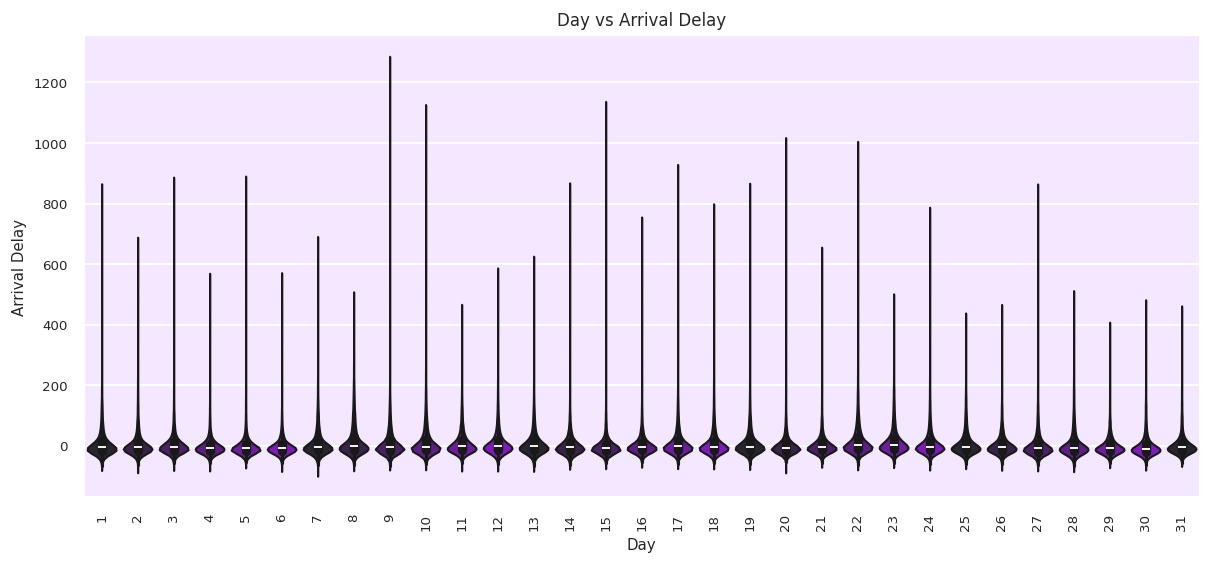

In [ ]:
plt.figure(figsize=(12,5))

sns.violinplot(x=df['day'], y=df['arr_delay'], palette=colors_box)

plt.title('Day vs Arrival Delay', fontsize=10)
plt.xlabel('Day', fontsize=9)
plt.ylabel('Arrival Delay', fontsize=9)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize = 8)
plt.show()

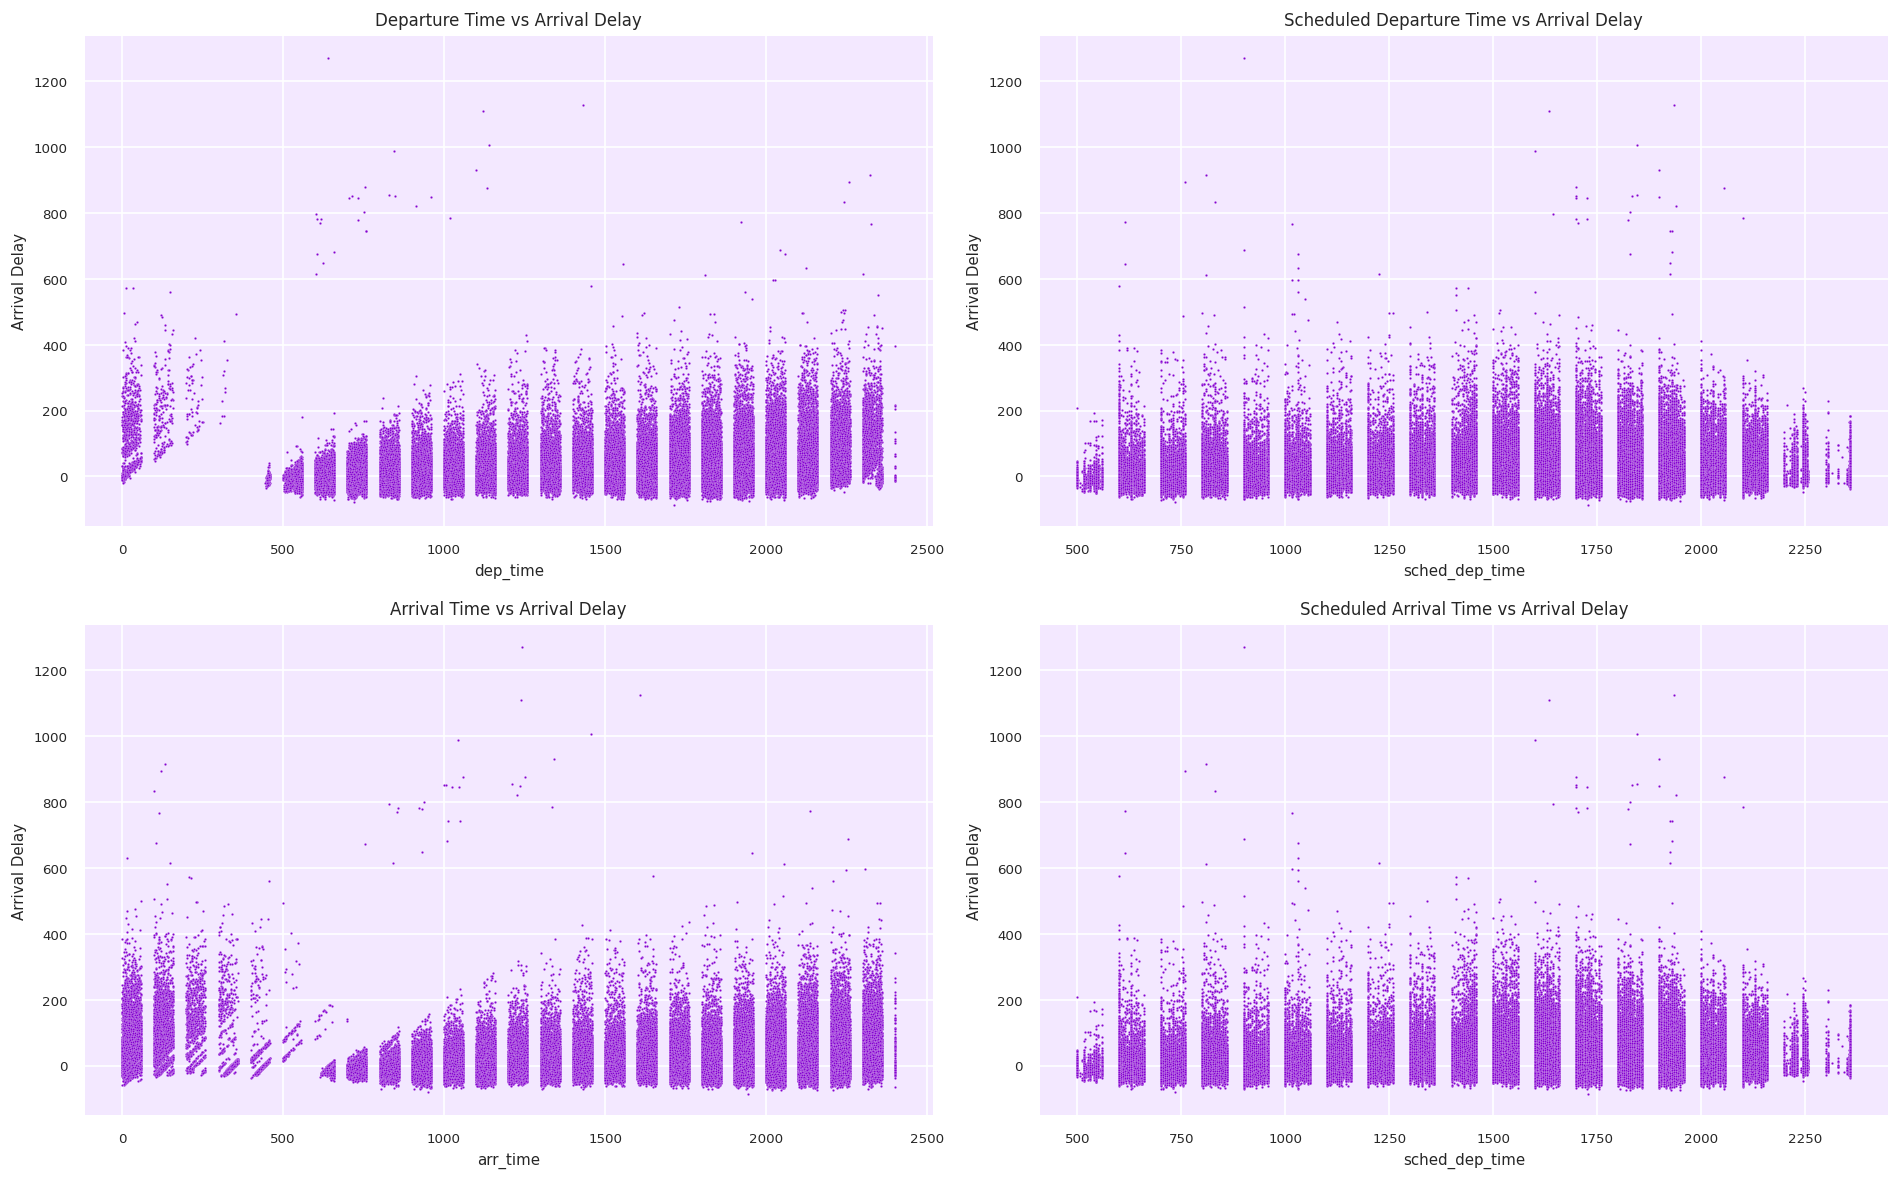

In [ ]:
to_plot = ['dep_time', 'sched_dep_time', 'arr_time',
           'sched_dep_time']
titles = ['Departure Time vs Arrival Delay',
          'Scheduled Departure Time vs Arrival Delay',
          'Arrival Time vs Arrival Delay',
          'Scheduled Arrival Time vs Arrival Delay']

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for i, col in enumerate(to_plot):
  x = i // 2
  y = i % 2

  sns.scatterplot(data = df, x = col, y = 'arr_delay', color = color,
                  ax = ax[x, y], s = 2)

  ax[x, y].set_xlabel(col, fontsize = 9)
  ax[x, y].set_ylabel('Arrival Delay', fontsize = 9)
  ax[x, y].set_title(titles[i], fontsize = 10)
  ax[x, y].tick_params(axis='x', labelsize=8)
  ax[x, y].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

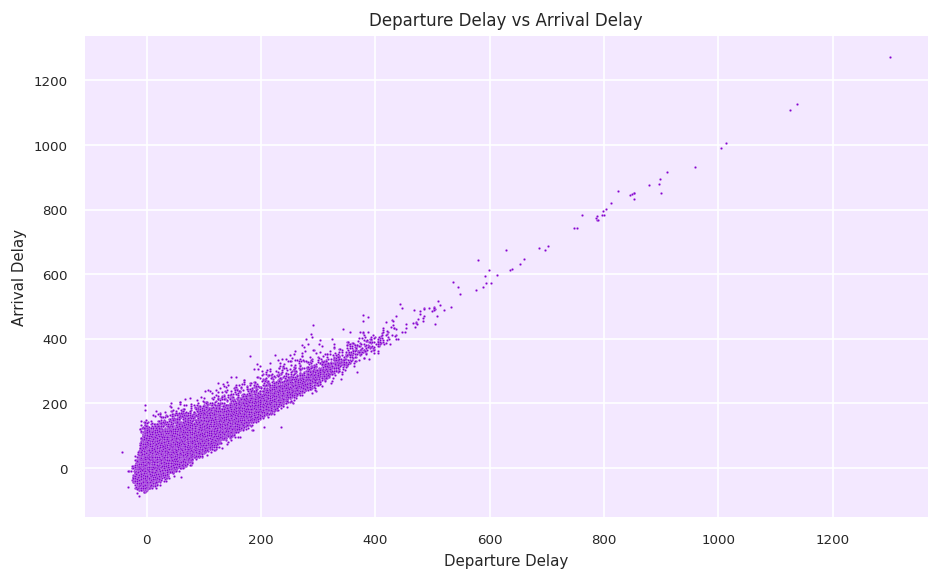

In [ ]:
plt.figure(figsize = (8, 5))

sns.scatterplot(data = df, x = "dep_delay", y = 'arr_delay', color = color,
                s = 2)

plt.xlabel("Departure Delay", fontsize = 9)
plt.ylabel('Arrival Delay', fontsize = 9)
plt.title('Departure Delay vs Arrival Delay', fontsize = 10)
plt.tick_params(axis = 'both', labelsize = 8)

plt.tight_layout()
plt.show()

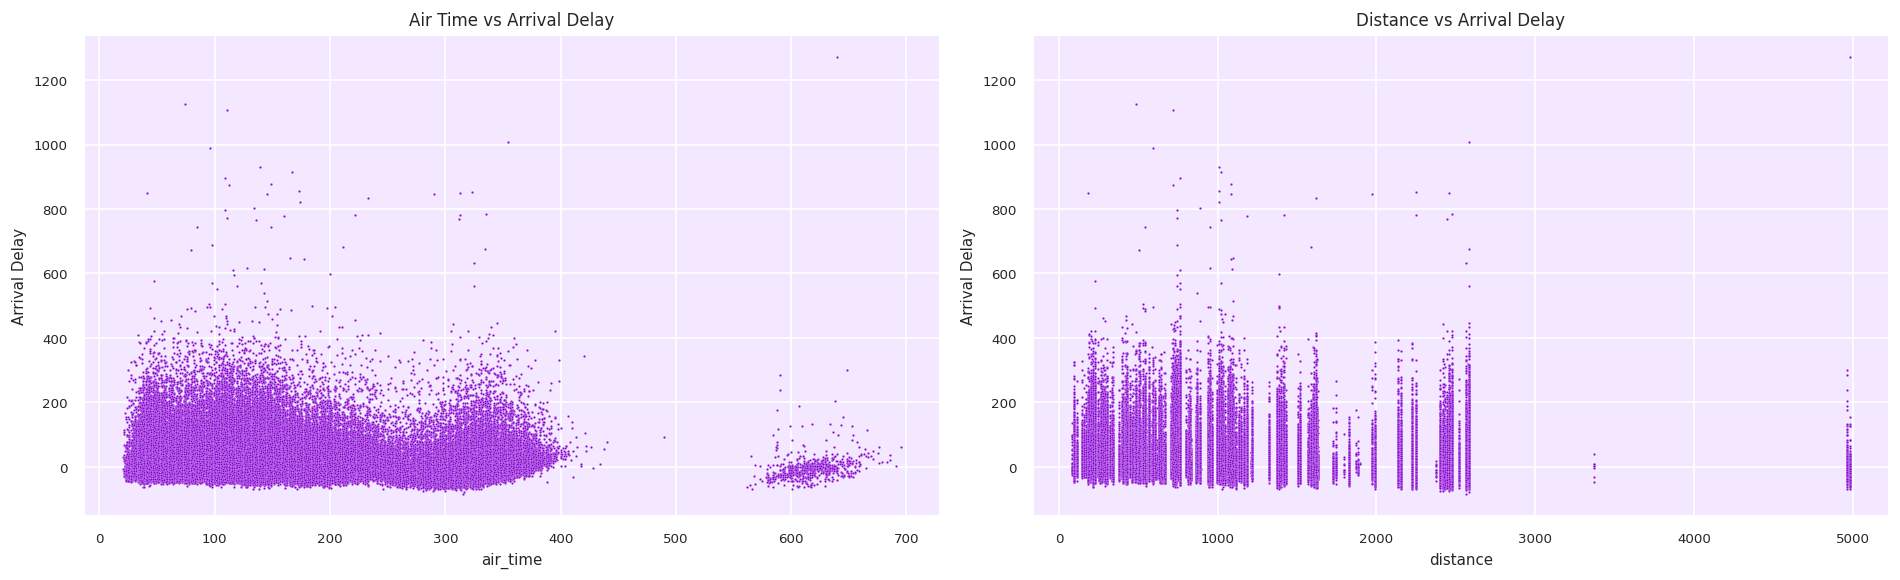

In [ ]:
to_plot = ['air_time', 'distance']
titles = ['Air Time vs Arrival Delay',
          'Distance vs Arrival Delay']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

for i, col in enumerate(to_plot):
  sns.scatterplot(data = df, x = col, y = 'arr_delay', color = color,
                  ax = ax[i], s = 2)

  ax[i].set_xlabel(col, fontsize = 9)
  ax[i].set_ylabel('Arrival Delay', fontsize = 9)
  ax[i].set_title(titles[i], fontsize = 10)
  ax[i].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

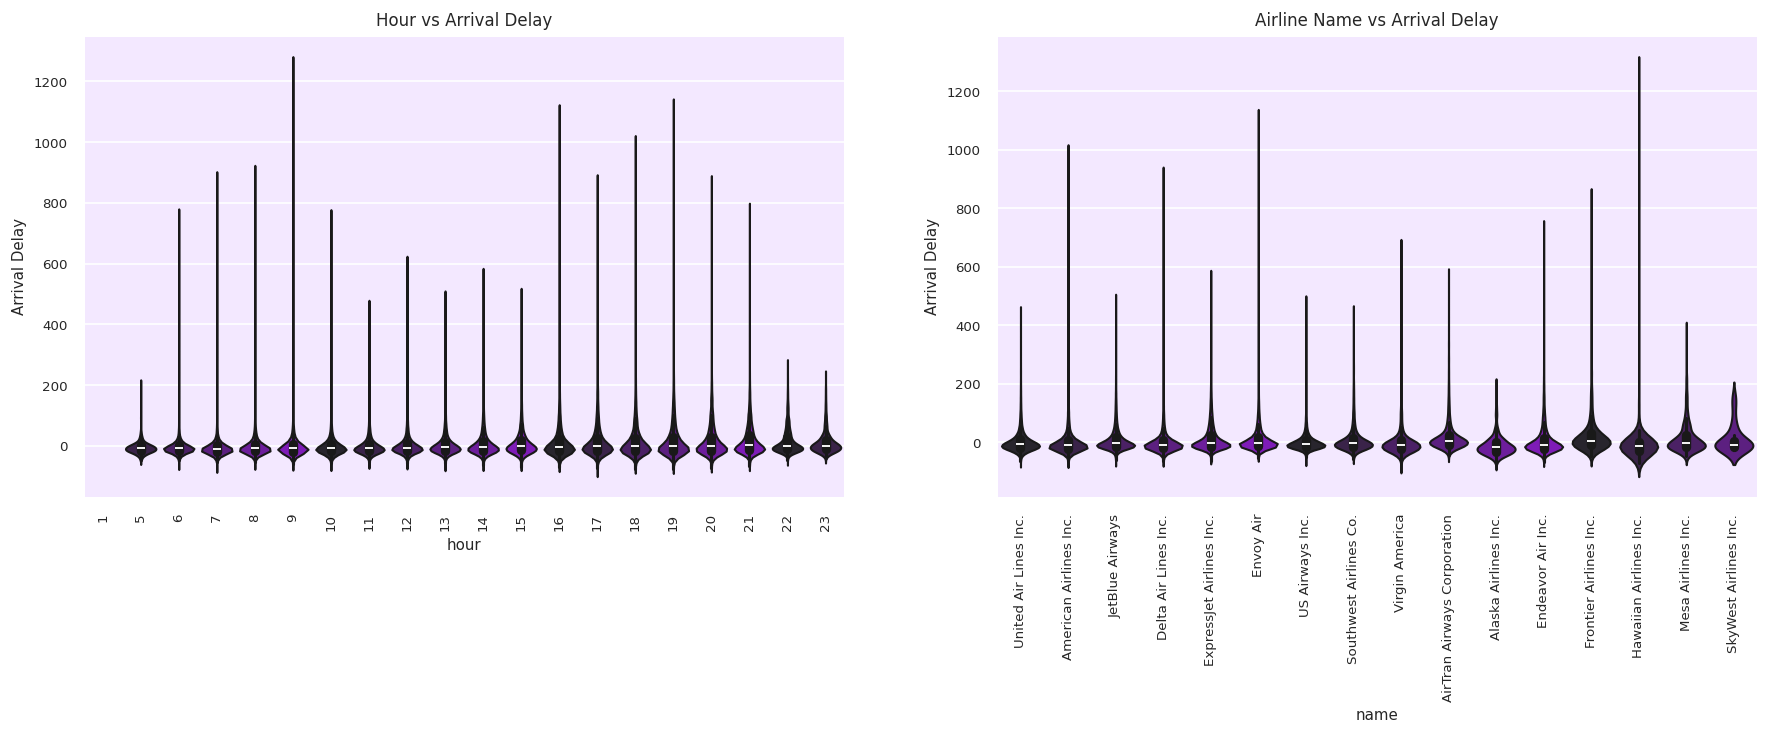

In [ ]:
to_plot = ['hour', 'name']
titles = ['Hour vs Arrival Delay', 'Airline Name vs Arrival Delay']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

for i, col in enumerate(to_plot):
  sns.violinplot(x = df[col], y = df['arr_delay'], palette = colors_box,
                 ax = ax[i])

  ax[i].set_xlabel(col, fontsize = 9)
  ax[i].set_ylabel('Arrival Delay', fontsize = 9)
  ax[i].set_title(titles[i], fontsize = 10)
  ax[i].tick_params(axis='x', labelsize=8, rotation = 90)
  ax[i].tick_params(axis='y', labelsize=8)

plt.show()

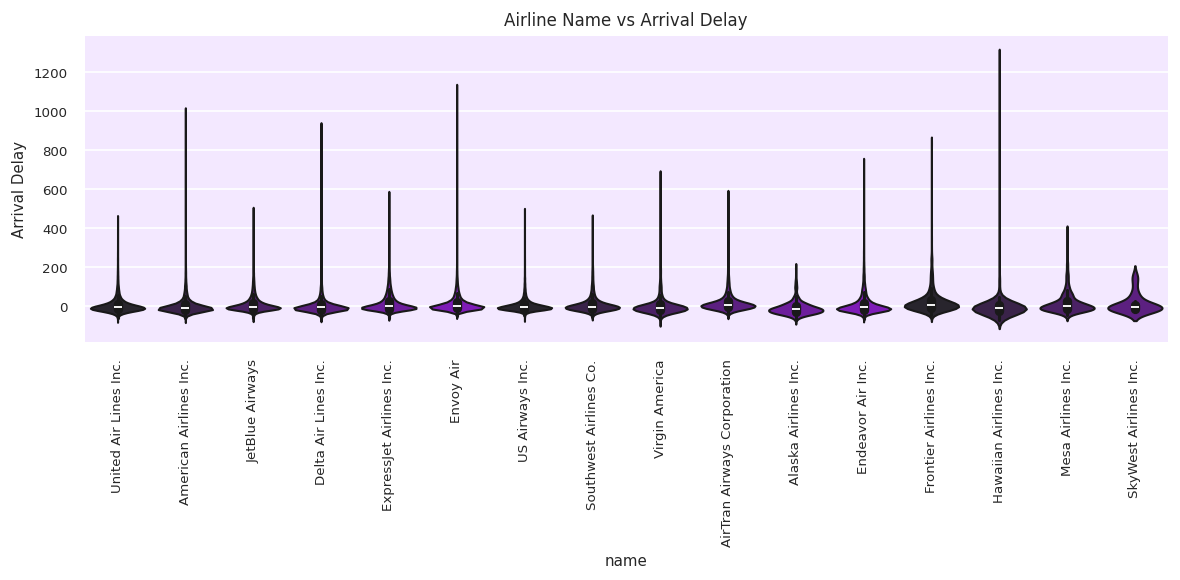

In [ ]:
plt.figure(figsize = (10, 5))

sns.violinplot(x = df['name'], y = df['arr_delay'], palette = colors_box)

plt.xlabel(col, fontsize = 9)
plt.ylabel('Arrival Delay', fontsize = 9)
plt.title(titles[i], fontsize = 10)
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8, rotation = 90)

plt.tight_layout()
plt.show()

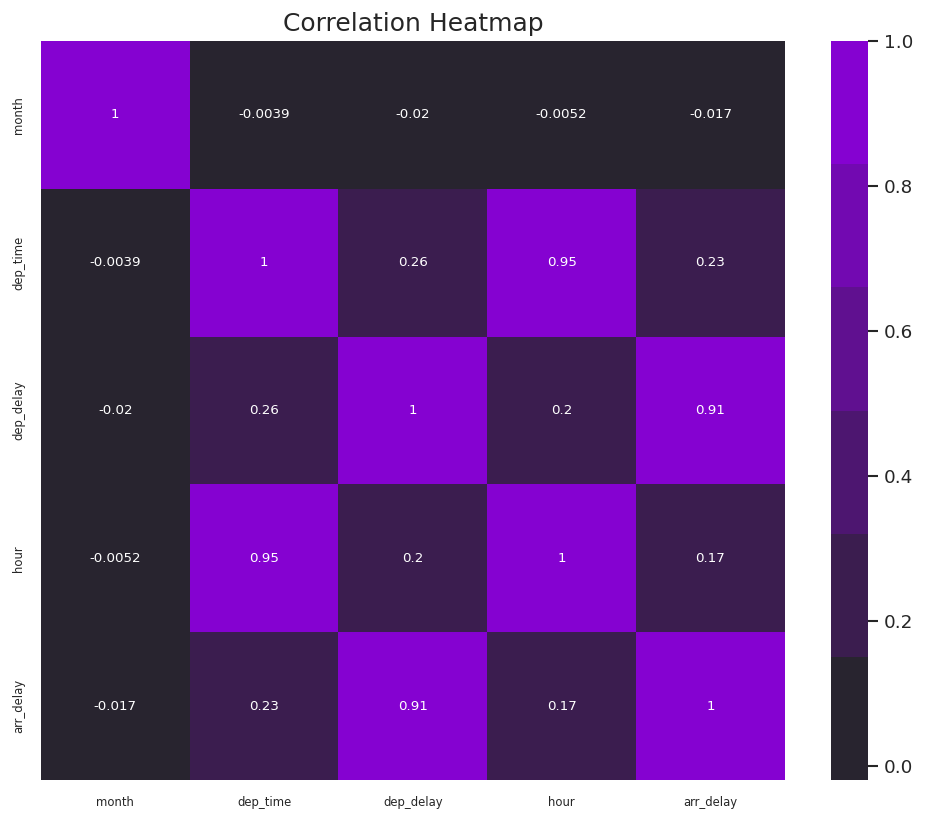

In [ ]:
colors_multi = sns.dark_palette('#8502d1', as_cmap = False)

numeric_features = ['month', 'dep_time', 'dep_delay', 'hour', 'arr_delay']
corr = df[numeric_features].corr()

plt.figure(figsize = (10, 8))

sns.heatmap(corr, annot = True, cmap = colors_multi, annot_kws = {'size': 8})
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.title('Correlation Heatmap', fontsize = 15)
plt.show()

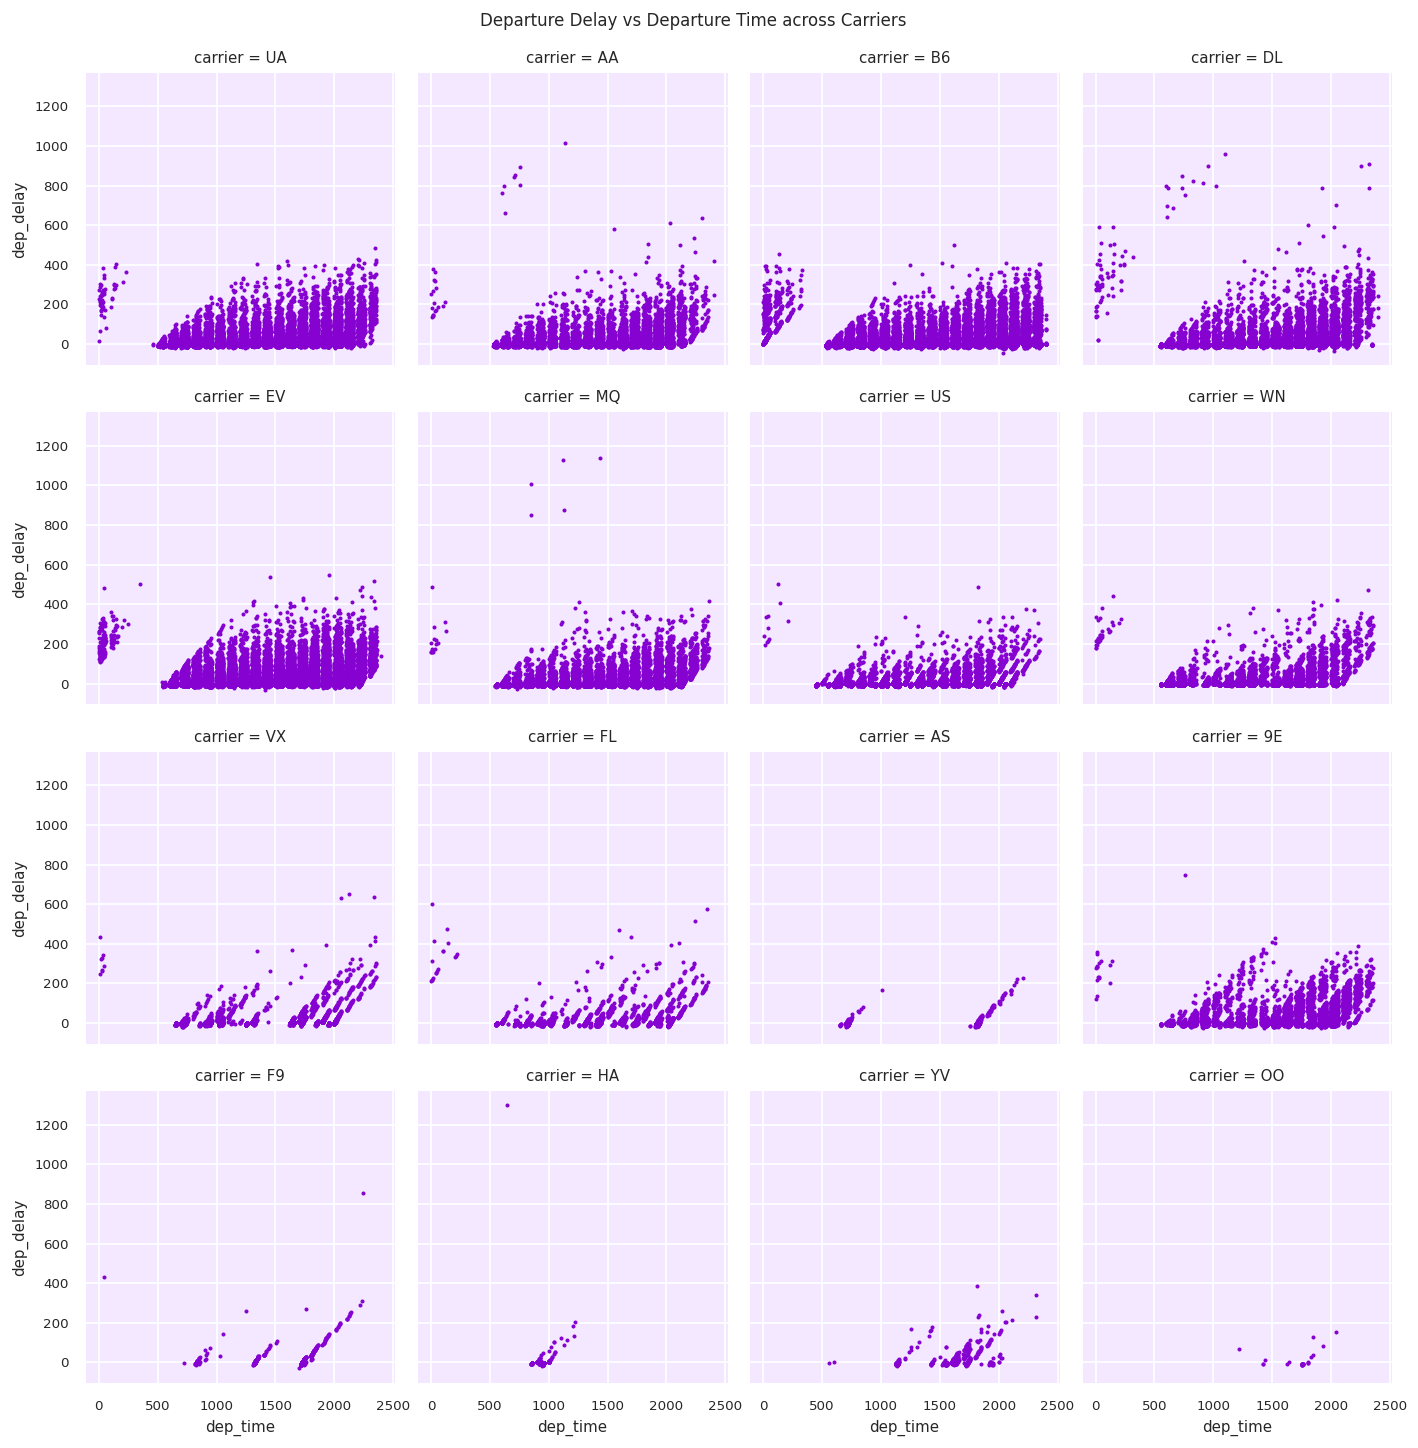

In [ ]:
g = sns.FacetGrid(df, col = 'carrier', col_wrap = 4, height = 3, aspect = 1)
g.map(plt.scatter, 'dep_time', 'dep_delay', color = color, s = 2)
g.fig.suptitle('Departure Delay vs Departure Time across Carriers',
               fontsize = 10, y = 1.01)

g.set_titles(size = 9)

for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel(ax.get_xlabel(), fontsize=9)
    ax.set_ylabel(ax.get_ylabel(), fontsize=9)

plt.show()

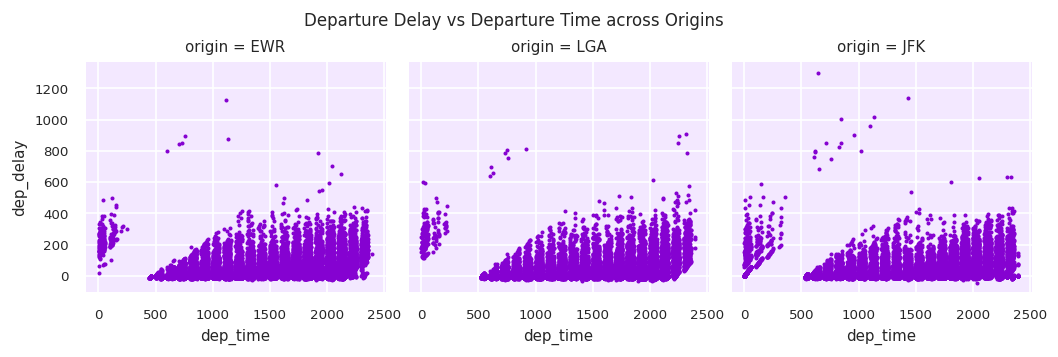

In [ ]:
g = sns.FacetGrid(df, col = 'origin', col_wrap = 3, height = 3, aspect = 1)
g.map(plt.scatter, 'dep_time', 'dep_delay', color = color, s = 2)
g.fig.suptitle('Departure Delay vs Departure Time across Origins',
               fontsize = 10, y = 1.01)

g.set_titles(size = 9)

for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel(ax.get_xlabel(), fontsize=9)
    ax.set_ylabel(ax.get_ylabel(), fontsize=9)

plt.show()

In [ ]:
to_drop = ['id', 'year', 'flight', 'time_hour', 'tailnum', 'minute', 'hour',
           'carrier']

df.drop(columns = to_drop, axis = 1, inplace = True)

In [ ]:
df.columns

Index(['month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time',
       'sched_arr_time', 'arr_delay', 'origin', 'dest', 'air_time', 'distance',
       'name'],
      dtype='object')

In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({'Missing Values': missing_values,
                             'Percentage': missing_percentage}).sort_values(
                                 by = 'Percentage', ascending = False)
print(missing_info)

                Missing Values  Percentage
arr_delay                 9430    2.800081
air_time                  9430    2.800081
arr_time                  8713    2.587180
dep_time                  8255    2.451184
dep_delay                 8255    2.451184
month                        0    0.000000
day                          0    0.000000
sched_dep_time               0    0.000000
sched_arr_time               0    0.000000
origin                       0    0.000000
dest                         0    0.000000
distance                     0    0.000000
name                         0    0.000000


In [ ]:
df.dropna(subset = ['arr_delay'], inplace = True)
df.reset_index(drop = True, inplace = True)

In [ ]:
X = df.drop(columns = ['arr_delay'])
y = df['arr_delay']

imputer = KNNImputer(n_neighbors = 5)

to_impute = ['air_time', 'arr_time', 'dep_time', 'dep_delay']

X[to_impute] = imputer.fit_transform(X[to_impute])

In [ ]:
X.isnull().sum().sum()

0

In [ ]:
to_check = ['arr_delay', 'air_time', 'arr_time', 'dep_time', 'dep_delay',
            'sched_dep_time', 'sched_arr_time', 'distance']

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

for column in to_check:
    outliers = detect_outliers_iqr(df, column)
    print(f"Number of outliers in {column}: {outliers.shape[0]}")

Number of outliers in arr_delay: 27880
Number of outliers in air_time: 5448
Number of outliers in arr_time: 0
Number of outliers in dep_time: 0
Number of outliers in dep_delay: 42857
Number of outliers in sched_dep_time: 0
Number of outliers in sched_arr_time: 0
Number of outliers in distance: 709


In [ ]:
cat_columns = X.select_dtypes(include = 'object').columns

X[cat_columns].nunique()

,0
origin,3
dest,104
name,16


In [ ]:
for col in cat_columns:
  print(f'Distribution of categories in {col}')
  print(X[col].value_counts())
  print("\n")

Distribution of categories in origin
origin
EWR    117127
JFK    109079
LGA    101140
Name: count, dtype: int64


Distribution of categories in dest
dest
ATL    16837
ORD    16566
LAX    16026
BOS    15022
MCO    13967
       ...  
HDN       14
MTJ       14
SBN       10
ANC        8
LEX        1
Name: count, Length: 104, dtype: int64


Distribution of categories in name
name
United Air Lines Inc.          57782
JetBlue Airways                54049
ExpressJet Airlines Inc.       51108
Delta Air Lines Inc.           47658
American Airlines Inc.         31947
Envoy Air                      25037
US Airways Inc.                19831
Endeavor Air Inc.              17294
Southwest Airlines Co.         12044
Virgin America                  5116
AirTran Airways Corporation     3175
Alaska Airlines Inc.             709
Frontier Airlines Inc.           681
Mesa Airlines Inc.               544
Hawaiian Airlines Inc.           342
SkyWest Airlines Inc.             29
Name: count, dtype: int64




In [ ]:
X_encoded = X.copy()

X_encoded = pd.get_dummies(df, columns = ['origin', 'name'], drop_first = True,
                                          dtype = int)

In [ ]:
dest_freq = X_encoded['dest'].value_counts() / len(X_encoded)
X_encoded['dest'] = X_encoded['dest'].map(dest_freq)

In [ ]:
def transform_time(df, columns):
  for col in columns:
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / 2400)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / 2400)

    df.drop(columns = [col], inplace = True)

  return df

In [ ]:
to_transform = ['dep_time', 'arr_time', 'sched_dep_time', 'sched_arr_time']

X_encoded = transform_time(X_encoded, to_transform)

In [ ]:
X_encoded.head()

,month,day,dep_delay,arr_delay,dest,air_time,distance,origin_JFK,origin_LGA,name_Alaska Airlines Inc.,...,name_United Air Lines Inc.,name_Virgin America,dep_time_sin,dep_time_cos,arr_time_sin,arr_time_cos,sched_dep_time_sin,sched_dep_time_cos,sched_arr_time_sin,sched_arr_time_cos
0,1,1,2.0,11.0,0.021644,227.0,1400,0,0,0,...,1,0,0.976485,0.215588,0.824126,-0.566406,0.975342,2.206974e-01,0.840094,-0.542442
1,1,1,4.0,20.0,0.021644,227.0,1416,0,1,0,...,1,0,0.984656,0.174508,0.793353,-0.608761,0.982774,1.848091e-01,0.824126,-0.566406
2,1,1,2.0,33.0,0.035415,160.0,1089,1,0,0,...,0,0,0.988494,0.151261,0.663273,-0.748377,0.987688,1.564345e-01,0.793353,-0.608761
3,1,1,-1.0,-18.0,0.002713,183.0,1576,1,0,0,...,0,0,0.989272,0.146083,0.490904,-0.871214,0.989651,1.434926e-01,0.449319,-0.893371
4,1,1,-6.0,-25.0,0.051435,116.0,762,0,1,0,...,0,0,0.992757,0.120137,0.849893,-0.526956,1.000000,6.123234e-17,0.813608,-0.581413


In [ ]:
binary_cols = [col for col in X_encoded.columns if X_encoded[col].value_counts().index.isin([0, 1]).all()]
cyclic_cols = [col for col in X_encoded.columns if col.endswith('_cos') or col.endswith('_sin')]
continuous_cols = [col for col in X_encoded.columns if col not in binary_cols + cyclic_cols]

In [ ]:
scaler = StandardScaler()

X_encoded[continuous_cols] = scaler.fit_transform(X_encoded[continuous_cols])
X_encoded.head()

,month,day,dep_delay,arr_delay,dest,air_time,distance,origin_JFK,origin_LGA,name_Alaska Airlines Inc.,...,name_United Air Lines Inc.,name_Virgin America,dep_time_sin,dep_time_cos,arr_time_sin,arr_time_cos,sched_dep_time_sin,sched_dep_time_cos,sched_arr_time_sin,sched_arr_time_cos
0,-1.630263,-1.679414,-0.263447,0.091963,-0.290559,0.814548,0.477816,0,0,0,...,1,0,0.976485,0.215588,0.824126,-0.566406,0.975342,2.206974e-01,0.840094,-0.542442
1,-1.630263,-1.679414,-0.213529,0.293607,-0.290559,0.814548,0.499558,0,1,0,...,1,0,0.984656,0.174508,0.793353,-0.608761,0.982774,1.848091e-01,0.824126,-0.566406
2,-1.630263,-1.679414,-0.263447,0.584870,0.558148,0.099410,0.055209,1,0,0,...,0,0,0.988494,0.151261,0.663273,-0.748377,0.987688,1.564345e-01,0.793353,-0.608761
3,-1.630263,-1.679414,-0.338324,-0.557777,-1.457249,0.344905,0.716977,1,0,0,...,0,0,0.989272,0.146083,0.490904,-0.871214,0.989651,1.434926e-01,0.449319,-0.893371
4,-1.630263,-1.679414,-0.463119,-0.714611,1.545420,-0.370233,-0.389140,0,1,0,...,0,0,0.992757,0.120137,0.849893,-0.526956,1.000000,6.123234e-17,0.813608,-0.581413


In [ ]:
def plot_hist(column, title, xlabel, color, bins = 30):
  sns.histplot(column, bins = bins, color = color, edgecolor = 'white',
               kde = True)
  plt.title(title, fontsize = 10)
  plt.xlabel(xlabel, fontsize = 9)
  plt.ylabel('Frequency', fontsize = 10)